In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import sys
sys.path.insert(0, '../')

from portfolio import *

# Load Data

In [2]:
rets = pd.read_excel('sp500_fundamentals.xlsx',sheet_name='total returns')
rets.set_index('Date',inplace=True)
signals = pd.read_excel('sp500_fundamentals.xlsx',sheet_name='fundamentals')
signals.set_index('Date',inplace=True)

# Backtest by using only point-in-time info

In [3]:
def forecast_OLS(X,y,x):
    reg = LinearRegression().fit(X,y)
    pred = reg.predict(x)[0][0]
    
    return pred

In [4]:
def forecast_Forest(X,y,x):

    y = y.ravel()
    forest = RandomForestRegressor(max_depth=2, criterion='mae',random_state=0)
    forest.fit(X,y)
    pred = forest.predict(x)
    
    return pred

In [5]:
def forecast_NN(X,y,x):
    
    y = y.ravel()
    mlp = MLPRegressor(hidden_layer_sizes=(100,100),random_state=0)
    mlp.fit(X,y)

    pred = mlp.predict(x)
    
    return pred

In [6]:
def forecast_iteration(Xraw,yraw,pred_method=forecast_OLS):
    n_regressors = Xraw.shape[1]
    n_sample = Xraw.shape[0]
    
    regdata = yraw.join(Xraw, how='inner').join(Xraw.shift(1), how='inner', rsuffix='_lag')
    regdata.dropna(axis=0,inplace=True)
    
    y = regdata.iloc[:,[0]]
    X = regdata.iloc[:,1: 1+n_regressors]
    Xlag = regdata.iloc[:, -n_regressors:]    

    pred = pd.Series(index=regdata.index,dtype='float64')
    for t in regdata.index[n_regressors:]:
        yt = y.loc[:t,:].values.reshape(-1,1)
        Xt = Xlag.loc[:t,:].values
        xt = X.loc[t,:].values.reshape(1,-1)

        pred.loc[t] = pred_method(Xt,yt,xt)        
        
    return pred

## Forecasts
### Optionally, use the Forest and Neural Network forecasts

In [7]:
target = rets[['SPY']]

forecasts_oos = pd.DataFrame()
forecasts_oos['Mean'] = target.expanding().mean().shift(1)['SPY']
forecasts_oos['DP'] = forecast_iteration(signals[['DP']],target)
forecasts_oos['EP'] = forecast_iteration(signals[['EP']],target)
forecasts_oos['ALL'] = forecast_iteration(signals,target)

### Optionally forecast with Machine Learning
#forecasts_oos['Forest'] = forecast_iteration(signals[['DP','EP']],target, pred_method=forecast_Forest)
#forecasts_oos['NN'] = forecast_iteration(signals[['DP','EP']],target, pred_method=forecast_NN)

# Erase predictions made with less than 5 years data
BURN_PERIODS = 60
forecasts_oos.iloc[:BURN_PERIODS,:] = None

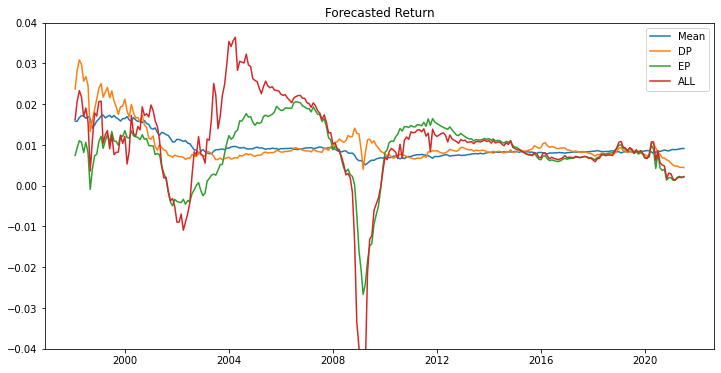

In [8]:
plot_data = forecasts_oos
fig = plt.figure(figsize=(12,6))
plt.plot(plot_data)
plt.ylim((-.04,.04))
plt.legend(plot_data.columns)
plt.title('Forecasted Return')
plt.show()

In [9]:
resids = forecasts_oos - target.values
sse = (resids ** 2).sum()
rsquared_oos = (1 - sse.divide(sse['Mean'],axis=0)).to_frame()
rsquared_oos.columns = ['OOS R-squared']
rsquared_oos.style.format({'OOS R-squared': '{:,.2%}'.format})

,OOS R-squared
Mean,0.00%
DP,1.37%
EP,1.68%
ALL,3.39%


In [10]:
funds_oos = forecasts_performance(forecasts_oos,target)
funds_oos.insert(0,'Passive',target)

In [11]:
print('Correlation of strategies:')
funds_oos.corr().style.format('{:,.1%}'.format)

Correlation of strategies:


,Passive,Mean,DP,EP,ALL
Passive,100.0%,94.4%,91.0%,44.6%,25.2%
Mean,94.4%,100.0%,95.5%,49.8%,36.8%
DP,91.0%,95.5%,100.0%,47.2%,31.2%
EP,44.6%,49.8%,47.2%,100.0%,87.3%
ALL,25.2%,36.8%,31.2%,87.3%,100.0%


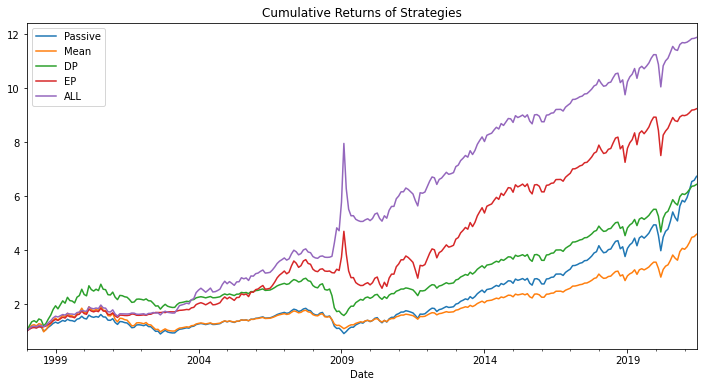

In [12]:
(funds_oos + 1).cumprod().plot(figsize=(12,6),title='Cumulative Returns of Strategies');

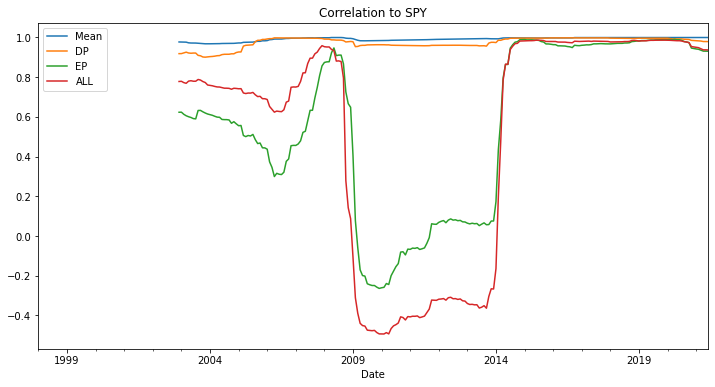

In [13]:
corr_rolling = funds_oos.rolling(60).corr()
dynamic_corrs = (corr_rolling['Passive'].unstack(1))
dynamic_corrs = dynamic_corrs.reindex(columns=funds_oos.columns).drop(columns=['Passive'])
dynamic_corrs.plot(figsize=(12,6), title='Correlation to SPY');

In [14]:
performanceMetrics(funds_oos,annualization=12).style.format('{:,.2%}'.format)

,Mean,Vol,Sharpe,Min,Max,VaR (0.05),CVaR (0.05)
Passive,9.32%,15.26%,61.09%,-16.52%,12.70%,-7.46%,-9.87%
Mean,7.58%,14.59%,51.95%,-21.98%,14.45%,-6.90%,-9.52%
DP,9.01%,14.59%,61.75%,-19.52%,16.33%,-5.39%,-8.72%
EP,10.55%,14.59%,72.31%,-17.85%,25.56%,-5.52%,-8.67%
ALL,11.58%,14.59%,79.36%,-21.07%,37.64%,-3.62%,-6.77%


In [15]:
df = maximumDrawdown(funds_oos)
df

,Max Drawdown,Peak,Bottom,Recover,Peak to Recover
Passive,-0.507980,2007-10-31,2009-02-28,2012-03-31,1613 days
Mean,-0.496326,2000-08-31,2002-09-30,2013-07-31,4717 days
DP,-0.466973,2007-10-31,2009-02-28,2013-03-31,1978 days
EP,-0.449343,2009-02-28,2010-06-30,2013-04-30,1522 days
ALL,-0.363649,2009-02-28,2009-09-30,2013-11-30,1736 days


In [16]:
df = get_ols_metrics(target, funds_oos, annualization=12)

df.style.format({
    'alpha': '{:,.2%}'.format,
    'Passive': '{:,.2f}'.format,
    'r-squared': '{:,.2%}'.format,
    'Info Ratio': '{:,.2%}'.format,
})

,alpha,SPY,r-squared,Info Ratio
Passive,-0.00%,1.000000,100.00%,nan%
Mean,-0.83%,0.902918,89.11%,-17.33%
DP,0.90%,0.870532,82.83%,14.85%
EP,6.57%,0.426756,19.91%,50.34%
ALL,9.34%,0.240792,6.34%,66.11%


# Comparison to the In-sample strategies

Compared to the in-sample strategy performance, (see `Demo Forecasting`,) the performance here is similar.

Notably, 
- the expanding mean is worse than Passive
- DP is poor, EP does well
- ALL does a bit better relatively than it did in-sample

If running the Machine-Learning forecasts,
- They are relatively better than the others OOS
- The NN is nearly uncorrelated to Passive OOS, though this is specific to the parameterization of the NN.

## A few take-aways

- OOS R-squared of the forecast is not indicative of which strategy will have best performance.
- Strategies are sensitive to the time period--post 2014, all of them have much higher correlation to Passive, and much worse relative performance than Passive.
- The machine learning strategies are hard to tune. Changing layers in NN makes a big difference.